In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
%matplotlib inline

### Packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings

In [2]:
data = pd.read_csv("../data/model_data.csv", index_col= False)
data.head(5)

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance_rest_del_loc,hour,day,weekday_name,TypeOfMeal
0,30.0,4.7,conditions Sandstorms,Jam,0.0,Meal,motorcycle,1.0,No,Metropolitian,34.0,10.336614,19,20,Sunday,Dinner
1,30.0,4.7,conditions Sandstorms,Jam,0.0,Buffet,motorcycle,1.0,No,Metropolitian,46.0,5.849717,20,30,Saturday,Dinner
2,30.0,4.7,conditions Sunny,Low,0.0,Drinks,motorcycle,1.0,No,Metropolitian,19.0,0.974953,9,28,Monday,Breakfast
3,30.0,4.7,conditions Cloudy,Medium,1.0,Drinks,motorcycle,1.0,No,Metropolitian,42.0,7.799623,18,20,Sunday,Dinner
4,30.0,4.7,conditions Windy,Jam,0.0,Snack,motorcycle,1.0,No,Metropolitian,44.0,10.724479,19,29,Tuesday,Dinner


In [3]:
data.dtypes

Delivery_person_Age        float64
Delivery_person_Ratings    float64
Weatherconditions           object
Road_traffic_density        object
Vehicle_condition          float64
Type_of_order               object
Type_of_vehicle             object
multiple_deliveries        float64
Festival                    object
City                        object
Time_taken(min)            float64
distance_rest_del_loc      float64
hour                         int64
day                          int64
weekday_name                object
TypeOfMeal                  object
dtype: object

In [4]:
### Features and Predictors(Target)
X = data.drop(['Time_taken(min)'], axis =1)
y = data['Time_taken(min)']

In [5]:
### Splitting the data into Train validation and test
X_train, X_test,y_train ,  y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_Val,  X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.33, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_Val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(30703, 15) (30703,)
(8816, 15) (8816,)
(4343, 15) (4343,)


In [6]:
### Feature Generation
### Convert the categorical features into numerical features

def convert_categorical_numerical(df, categorical_columns):

    encoder = OneHotEncoder(sparse_output = False)
    one_hot_encoded = encoder.fit_transform(df[categorical_columns])
    one_hot_data = pd.DataFrame(one_hot_encoded, 
                                columns = encoder.get_feature_names_out(categorical_columns)) 
    df_rest_index = df.reset_index(drop = True, inplace = False)   
    df_encoded = pd.concat([df_rest_index, one_hot_data], axis =1)
    df_encoded = df_encoded.drop(columns = categorical_columns, axis =1)
    return df_encoded



In [7]:
def feature_scaling_numeric_columns(df, numerical_columns):

    print(numerical_columns)
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

In [8]:
def data_preprocessing(data):
    numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns

    data_encoded = convert_categorical_numerical(data, categorical_features)
    data_scaled = feature_scaling_numeric_columns(data_encoded, numerical_features)
    return data_scaled

In [9]:
### Applying various ML models
def model_training(X_train, X_test, y_train, y_test, ml_model):
    # Train the model
    ml_model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = ml_model.predict(X_train)
    y_pred_test = ml_model.predict(X_test)

    # Evaluate the model
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared= False) 

    print(f"Model: {ml_model.__class__.__name__}")
    print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")

    print('-' * 50)

    return ml_model, test_mse, test_r2, test_rmse

In [13]:


# Suppress all warnings
warnings.filterwarnings("ignore")

X_train_pre = data_preprocessing(X_train)
X_Val_pre = data_preprocessing(X_Val)
X_test_pre = data_preprocessing(X_test)

models = [
    LinearRegression(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    XGBRegressor(n_estimators=100, random_state=42),
    LGBMRegressor(n_estimators=100, random_state=42)
]

# Train and evaluate each model
trained_models = {}
for model in models:
    trained_model, test_mse, r2,rmse = model_training(X_train_pre, X_Val_pre, y_train, y_val, model)
    trained_models[model.__class__.__name__] = {'model': trained_model, 'val_mse': test_mse, 'r2_score': r2, 'rmse': rmse}


for model in models:
    trained_model, test_mse, r2,rmse = model_training(X_train_pre, X_test_pre, y_train, y_test, model)
    trained_models[model.__class__.__name__] = {'model': trained_model, 'test_mse': test_mse, 'r2_score': r2, 'rmse': rmse}



Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'distance_rest_del_loc', 'hour', 'day'],
      dtype='object')
Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'distance_rest_del_loc', 'hour', 'day'],
      dtype='object')
Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'distance_rest_del_loc', 'hour', 'day'],
      dtype='object')
Model: LinearRegression
Train MSE: 35.1338, Test MSE: 35.3619, R2 Score: 0.5958
--------------------------------------------------
Model: RandomForestRegressor
Train MSE: 2.0676, Test MSE: 15.1101, R2 Score: 0.8273
--------------------------------------------------
Model: XGBRegressor
Train MSE: 10.3564, Test MSE: 28.1362, R2 Score: 0.6784
--------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [In

### LightGBM model is performing better 

In [18]:
import  lightgbm as lgb
hyper_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'feature_fraction': 0.9
}

In [19]:
X_train_pre = data_preprocessing(X_train)
X_Val_pre = data_preprocessing(X_Val)
X_test_pre = data_preprocessing(X_test)
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train_pre, y_train,
        eval_set=[(X_test_pre, y_test)],
        eval_metric='l1')

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'distance_rest_del_loc', 'hour', 'day'],
      dtype='object')
Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'distance_rest_del_loc', 'hour', 'day'],
      dtype='object')
Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'distance_rest_del_loc', 'hour', 'day'],
      dtype='object')
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=10, subsample_f

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              metric='rmse', objective='regression')

In [31]:

y_pred_test = gbm.predict(X_test_pre)

# Evaluate the model
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared= False) 

print(f"Model: {gbm.__class__.__name__}")
print(f"Test MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}, RMSE: {test_rmse:.4f}")

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Model: LGBMRegressor
Test MSE: 14.3648, R2 Score: 0.8341, RMSE: 3.7901


In [32]:
def GetMetrics(y, predictions):
    return {'MSE' : mean_squared_error(y, predictions),
            'RMSE' : np.sqrt(mean_squared_error(y, predictions)),
            'MAE': mean_absolute_error(y, predictions)}

In [33]:
### Getting predictions

from sklearn.metrics import explained_variance_score, max_error
Summary = pd.DataFrame(GetMetrics(y = y_test, predictions = y_pred_test), index = ['Score'])

Summary['Explained Variance'] = explained_variance_score(y_test, y_pred_test)
Summary['Max Error'] = max_error(y_test, y_pred_test)

In [34]:
Summary

,MSE,RMSE,MAE,Explained Variance,Max Error
Score,14.364835,3.790097,3.041822,0.834087,15.541632


In [35]:
predictions = y_pred_test

In [39]:
ComparationTable = pd.DataFrame({
    'Real Value' : y_test.values,
    'Model Prediction' : [round(item) for item in y_pred_test],
    'Difference' : y_test.values - [round(item) for item in y_pred_test],
    'Difference %' : np.absolute((y_test.values - [round(item) for item in y_pred_test]) / y_test.values * 100)})

ComparationTable.head()

,Real Value,Model Prediction,Difference,Difference %
0,30.0,38,-8.0,26.666667
1,18.0,18,0.0,0.000000
2,25.0,22,3.0,12.000000
3,38.0,37,1.0,2.631579
4,32.0,36,-4.0,12.500000


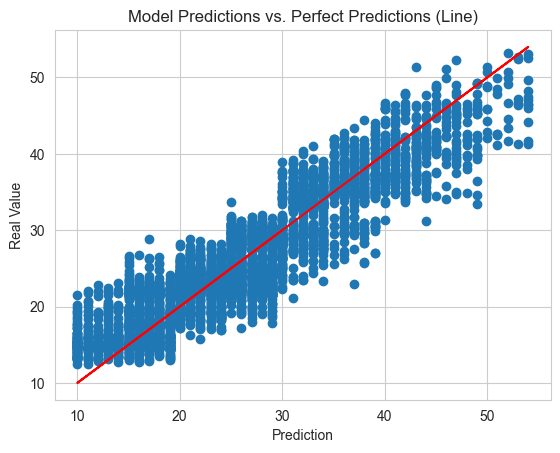

In [40]:
# Our predictions
plt.scatter(y_test, predictions)

# Perfect predictions
plt.plot(y_test, y_test, 'r')
plt.ylabel('Real Value')
plt.xlabel('Prediction')
plt.title('Model Predictions vs. Perfect Predictions (Line)');

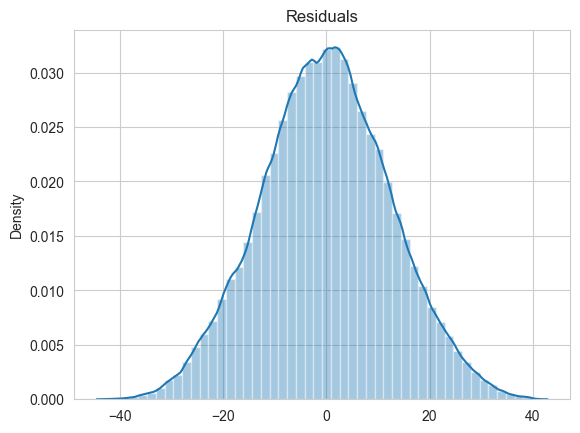

In [42]:
errors = y_test.values.reshape(-1, 1) - predictions
sns.distplot(errors)
plt.title('Residuals');

In [43]:
# Worst predictions
ComparationTable.sort_values(by = 'Difference %', ascending = False).head(10)

,Real Value,Model Prediction,Difference,Difference %
288,10.0,22,-12.0,120.000000
2093,11.0,22,-11.0,100.000000
3743,11.0,22,-11.0,100.000000
2107,10.0,20,-10.0,100.000000
3315,10.0,20,-10.0,100.000000
1357,12.0,23,-11.0,91.666667
2221,11.0,21,-10.0,90.909091
732,11.0,21,-10.0,90.909091
4291,10.0,19,-9.0,90.000000
125,10.0,19,-9.0,90.000000


In [44]:
# Best predictions
ComparationTable.sort_values(by = 'Difference %', ascending = True).head(10)

,Real Value,Model Prediction,Difference,Difference %
3697,32.0,32,0.0,0.0
3114,22.0,22,0.0,0.0
660,29.0,29,0.0,0.0
3106,36.0,36,0.0,0.0
1899,30.0,30,0.0,0.0
1900,24.0,24,0.0,0.0
3904,28.0,28,0.0,0.0
916,25.0,25,0.0,0.0
3501,46.0,46,0.0,0.0
3079,15.0,15,0.0,0.0


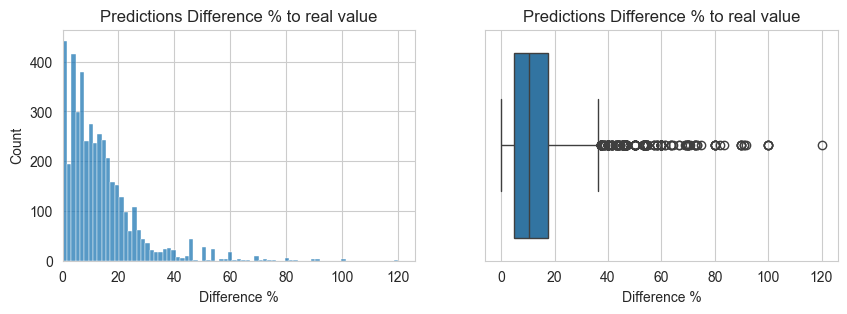

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 3))
sns.histplot(data = ComparationTable, x = 'Difference %', ax = ax1)
ax1.set_xlim(left = 0)
ax1.set_title('Predictions Difference % to real value')

sns.boxplot(data = ComparationTable, x = 'Difference %', ax = ax2)
ax2.set_title('Predictions Difference % to real value');

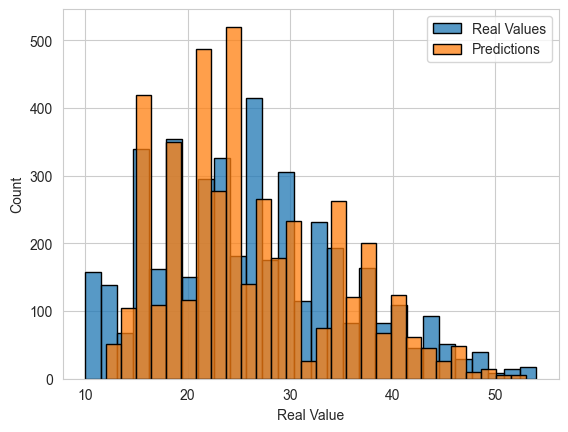

In [46]:
sns.histplot(data = ComparationTable, x = 'Real Value', label = 'Real Values', edgecolor = 'k')
sns.histplot(data = ComparationTable, x = 'Model Prediction', label = 'Predictions', edgecolor = 'k')
plt.legend();

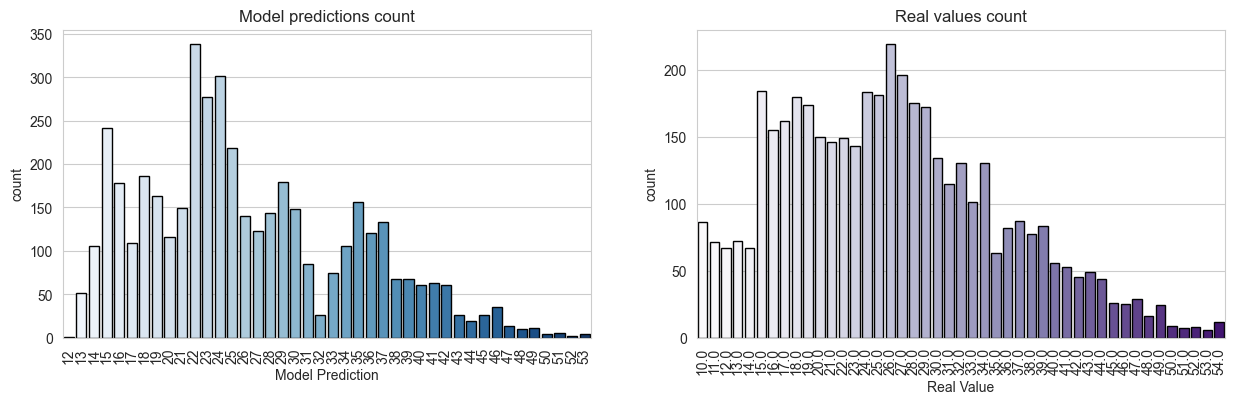

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1,figsize = (15, 4))
sns.countplot(data = ComparationTable, x = 'Model Prediction', ax = ax1, edgecolor = 'k', palette = 'Blues')
ax1.set_title('Model predictions count')
sns.countplot(data = ComparationTable, x = 'Real Value', ax = ax2, edgecolor = 'k', palette = 'Purples')
ax2.set_title('Real values count')

for ax in [ax1, ax2]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

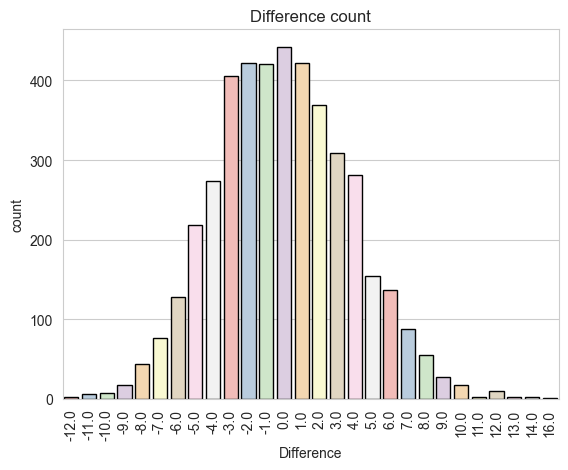

In [48]:
sns.countplot(data = ComparationTable, x = 'Difference', edgecolor = 'k', palette = 'Pastel1')
plt.xticks(rotation = 90)
plt.title('Difference count');

In [50]:
ComparationTable['Difference'].value_counts().to_frame().head(10)

,count
Difference,
0.0,442
1.0,422
-2.0,422
-1.0,420
-3.0,406
2.0,369
3.0,309
4.0,281
-4.0,274


## Applying neural networks

In [53]:
import torch
from torch import nn
from torch.utils.data import DataLoader


In [62]:
### Define Neural Network
class Regression_nn_model(nn.Module):
    def __init__(self, num_feature):
        super().__init__()

        self.layer1 = nn.Linear(num_feature, 39)
        self.layer2 = nn.ReLU()
        self.layer3 = nn.Linear(39, 20)
        self.layer4 = nn.ReLU()
        self.layer5 = nn.Linear(20, 1)

    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.layer5(output)

        return output



In [1]:
from torch.utils.data import DataLoader, Dataset
class myDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype = torch.float32)
        self.labels = torch.tensor(y, dtype = torch.float32)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]

        return x,y
    def __len__(self):
        return self.labels.shape[0]
    


train_ds = myDataset(X_train_pre, y_train)

train_loader = DataLoader(
dataset=train_ds,
batch_size=20,
shuffle=True,
)

NameError: name 'X_train_pre' is not defined

In [65]:
import torch
from torch.utils.data import DataLoader, Dataset

# Define your dataset class
class myDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X.values, dtype=torch.float32)
        self.targets = torch.tensor(y.values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.targets)  # Return the length of the dataset
    
    def __getitem__(self, index):
        # Return the feature-target pair for the given index
        return self.features[index], self.targets[index]

# Assuming you have X_train_pre and y_train as your data
# Now, you can instantiate the dataset and data loader
train_ds = myDataset(X_train_pre, y_train)

# Create DataLoader
train_loader = DataLoader(
    dataset=train_ds,
    batch_size=20,
    shuffle=True
)







In [61]:
X_train_pre.shape, y_train.shape

((30703, 39), (30703,))

In [ ]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=1)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

num_epochs = 50

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        logits = model(features)
        loss = F.mse_loss(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())